In [1]:
from collections.abc import Sequence
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from scipy.spatial.distance import euclidean
from scipy.spatial.transform import Rotation
import vedo

from histalign.backend.ccf.paths import get_atlas_path
from histalign.backend.io import load_volume
from histalign.backend.maths import compute_centre, compute_normal_from_raw
from histalign.backend.models import (
    Orientation,
    Resolution,
    VolumeSettings,
)
from histalign.backend.models.errors import InvalidOrientationError

vedo.settings.default_backend = "vtk"

In [2]:
def imshow(image: np.ndarray) -> None:
    _ = plt.figure()

    plt.imshow(image)
    plt.axis(False)

    plt.show()


def show(
    meshes: vedo.CommonVisual | list[vedo.CommonVisual], camera: dict | None = None
) -> None:
    plotter = vedo.Plotter(axes=4)

    if not isinstance(meshes, list):
        meshes = [meshes]

    for mesh in meshes:
        plotter += mesh

    plotter.show(interactive=False, camera=camera).interactive().close()


def compute_origin_from_raw(
    centre: Sequence[int], offset: int, orientation: Orientation
) -> np.ndarray:
    if len(centre) != 3:
        raise ValueError(f"Centre should be 3 coordinates. Got {len(centre)}.")

    match orientation:
        case Orientation.CORONAL:
            origin = [centre[0] + offset, centre[1], centre[2]]
        case Orientation.HORIZONTAL:
            origin = [centre[0], centre[1] + offset, centre[2]]
        case Orientation.SAGITTAL:
            origin = [centre[0], centre[1], centre[2] + offset]
        case other:
            raise InvalidOrientationError(other)

    return np.array(origin)


def signed_vector_angle(v1, v2, normal):
    return math.degrees(math.atan2(np.dot((np.cross(v1, v2)), normal), np.dot(v1, v2)))


def reproduce_display_plane(
    origin: np.ndarray, shape, settings: VolumeSettings
) -> vedo.Plane:
    """Reproduces the slicing alignment plane but centred at `origin`.

    Args:
        origin (np.ndarray): Origin of the plane.
        settings (VolumeSettings): Settings used for alignment.

    Returns:
        vedo.Plane:
            A plane centred at `origin` and whose normal is the same as the plane
            described by `settings`.
    """
    global display_shape

    orientation = settings.orientation
    pitch = settings.pitch
    yaw = settings.yaw

    display_shape = (1.5 * max(settings.shape),) * 2

    display_plane = vedo.Plane(
        pos=origin,
        normal=compute_normal_from_raw(0, 0, orientation),
        s=(1.5 * max(settings.shape),) * 2,
        # s=shape[::-1],
    )

    match orientation:
        case Orientation.CORONAL:
            display_plane.rotate(pitch, axis=[0, 0, 1], point=origin)
            display_plane.rotate(
                yaw,
                axis=Rotation.from_euler("Z", pitch, degrees=True).apply([0, 1, 0]),
                point=origin,
            )
            display_plane.rotate(
                -pitch,
                axis=Rotation.from_euler("ZY", [pitch, yaw], degrees=True).apply(
                    [1, 0, 0]
                ),
                point=origin,
            )
        case Orientation.HORIZONTAL:
            display_plane.rotate(180, axis=[0, 1, 0], point=origin)
            display_plane.rotate(pitch, axis=[0, 0, 1], point=origin)
            display_plane.rotate(
                yaw,
                axis=Rotation.from_euler("Z", pitch, degrees=True).apply([1, 0, 0]),
                point=origin,
            )
            display_plane.rotate(
                90 - pitch,
                axis=Rotation.from_euler("ZX", [pitch, yaw], degrees=True).apply(
                    [0, 1, 0]
                ),
                point=origin,
            )
        case Orientation.SAGITTAL:
            # Pitch
            display_plane.rotate(pitch, axis=[1, 0, 0], point=origin)
            # Yaw
            display_plane.rotate(
                yaw,
                axis=Rotation.from_euler("X", pitch, degrees=True).apply([0, 1, 0]),
                point=origin,
            )

    return display_plane


def crop_and_pad_to_display_plane(
    image_plane: vedo.Mesh,
    display_plane: vedo.Plane,
    origin: np.ndarray,
    normal: np.ndarray,
    settings: VolumeSettings,
) -> np.ndarray:
    orientation = settings.orientation
    pitch = settings.pitch
    yaw = settings.yaw

    A, _, D, C = find_corners(image_plane)
    a, b, d, c = display_plane.points

    if orientation == Orientation.SAGITTAL:
        # Mimic vedo rotation
        display_plane.rotate(
            signed_vector_angle(a - d, A - D, normal),
            axis=Rotation.from_euler("XY", [pitch, yaw], degrees=True).apply([0, 0, 1]),
            point=origin,
        )
        a, b, d, c = display_plane.points

    e = euclidean(A, a)
    e_prime = euclidean(C, c)

    theta = signed_vector_angle(A - a, a - d, normal)
    theta_prime = signed_vector_angle(C - c, b - c, normal)

    x, y, x_prime, y_prime = extract_values(e, theta, e_prime, theta_prime)

    match settings.orientation:
        case Orientation.CORONAL:
            x += 1
            y_prime -= 1
        case Orientation.HORIZONTAL:
            x_prime -= 1
            y += 1
        case Orientation.SAGITTAL:
            x += 1
            y += 1

    image = image_plane.pointdata["ImageScalars"].reshape(image_plane.metadata["shape"])
    image = image[
        x if x > 0 else 0 : image.shape[0] - (-x_prime if x_prime < 0 else 0),
        y if y > 0 else 0 : image.shape[1] - (-y_prime if y_prime < 0 else 0),
    ]
    image = np.pad(
        image,
        (
            [-x if x < 0 else 0, x_prime if x_prime > 0 else 0],
            [-y if y < 0 else 0, y_prime if y_prime > 0 else 0],
        ),
    )

    return image


def find_corners(
    plane_mesh: vedo.Mesh,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    shape = plane_mesh.metadata["shape"]
    corners = plane_mesh.points[[0, shape[1] - 1, -shape[1], -1]]

    return corners


def extract_values(e, theta, e_prime, theta_prime) -> tuple[int, int, int, int]:
    x = e * math.cos(math.radians(theta))
    y = e * math.sin(math.radians(theta))
    x_prime = e_prime * math.cos(math.radians(theta_prime))
    y_prime = e_prime * math.sin(math.radians(theta_prime))

    print(f"{x=}, {x_prime=}, {y=}, {y_prime=}")

    x = round(x)
    y = round(y)
    x_prime = round(x_prime)
    y_prime = round(y_prime)

    print(f"{x=}, {x_prime=}, {y=}, {y_prime=}")

    return x, y, x_prime, y_prime


def simulate() -> None:
    global volume

    global settings
    global origin
    global normal

    global plane_mesh
    global display_plane
    global plane_array

    offset = settings.offset
    pitch = settings.pitch
    yaw = settings.yaw

    origin = compute_origin_from_raw(
        compute_centre(volume.shape), offset, settings.orientation
    )
    normal = compute_normal_from_raw(pitch, yaw, settings.orientation).tolist()

    plane_mesh = volume.slice_plane(
        origin=origin,
        normal=normal,
        autocrop=False,
    )
    plane_mesh.color("blue")

    display_plane = reproduce_display_plane(
        origin, plane_mesh.metadata["shape"], settings
    )
    plane_array = crop_and_pad_to_display_plane(
        plane_mesh, display_plane, origin, normal, settings
    )

    if settings.orientation == Orientation.CORONAL:
        plane_array = ndimage.rotate(plane_array, settings.pitch, reshape=False)
        plane_array = np.fliplr(plane_array)
    elif settings.orientation == Orientation.HORIZONTAL:
        plane_array = ndimage.rotate(plane_array, settings.pitch - 90, reshape=False)

In [3]:
volume = load_volume(get_atlas_path(Resolution.MICRONS_100))

array = np.zeros(volume.shape, dtype=np.uint8)
array[:, :, (array.shape[2] - 1) // 2] = 255
volume = vedo.Volume(array)

settings = VolumeSettings(
    orientation=Orientation.SAGITTAL,
    resolution=Resolution.MICRONS_100,
    shape=volume.shape,
)

# display_shape = (1.5 * max(settings.shape),) * 2
# display_shape = (80, 114)[::-1]
display_shape = None

origin = None
normal = None

plane_mesh = None
display_plane = None
plane_array = None

In [4]:
settings.offset, settings.pitch, settings.yaw = 40, 50, 20
simulate()

x=6.483184353407017, x_prime=49.48318303643772, y=-26.939841846607546, y_prime=-0.9398354217936256
x=6, x_prime=49, y=-27, y_prime=-1


In [26]:
print(f"Plane mesh shape:     {tuple(plane_mesh.metadata['shape'])}")
print(f"Display plane shape:  {tuple(display_shape)[::-1]}")
print(f"Plane array shape:    {plane_array.shape}")

print(f"Origin:               {origin}")
print(f"Plane mesh centre:    {plane_mesh.center_of_mass()}")
print(f"Display plane centre: {display_plane.center_of_mass()}")

Plane mesh shape:     (156, 173)
Display plane shape:  (198.0, 198.0)
Plane array shape:    (198, 198)
Origin:               [65 39 96]
Plane mesh centre:    [73.62809129 22.19639812 71.08870113]
Display plane centre: [64.99999857 38.99999952 95.99999619]


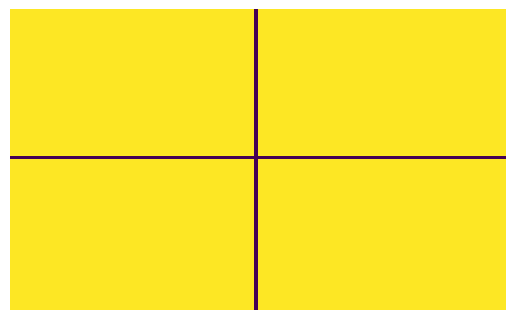

In [13]:
plane_array[(plane_array.shape[0] - 1) // 2] = 100
plane_array[..., (plane_array.shape[1] - 1) // 2] = 100

imshow(plane_array)

In [14]:
camera = dict(
    position=(-400, 40, 80),
    focal_point=origin,
    viewup=(0, 0, 1),
    roll=90,
)

show(
    [
        volume,
        vedo.Box(volume.bounds()).alpha(0.5),
        vedo.Point(origin, r=20, c="red"),
        plane_mesh,
        display_plane,
    ],
    camera=camera,
)